In [43]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from datetime import date

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [44]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 10:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [45]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [46]:
BASE_URL = 'https://finance.yahoo.com' #Global Variable 

def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #time
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'url' : BASE_URL + news_url,
            'content' : news_content,
           }

In [47]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

In [48]:
# url = 'https://finance.yahoo.com/topic/stock-market-news/'
# doc = get_page(url)
# news_list = get_news_tags(doc)
# news_list

## Collecting Stock Market News From Yahoo Finance

In [49]:
# from datetime import datetime

# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")
# print("Report Date = ", date.today())
# print("Report Time =", current_time)
# YAHOO_NEWS_URL = BASE_URL + '/topic/stock-market-news/'
# news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2022-12-17
Report Time = 12:58:40


In [50]:
# from transformers import pipeline

# import warnings
# warnings.filterwarnings("ignore")

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

### Sentiment Analysis of Yahoo Finance

In [51]:
# sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# sentiment = [None] * len(news_df)
# sentiment_score = [None] * len(news_df)
# index = -1
# for sentence in news_df['headline']:
#     index+=1
#     result = sentiment_pipeline(sentence[:512])[0]
#     sentiment[index] = result['label']
#     sentiment_score[index] = result['score']
# news_df['Sentiment'] = sentiment
# news_df['Score'] = sentiment_score


# sentiment = [None] * len(news_df)
# sentiment_score = [None] * len(news_df)
# index = -1
# for sentence in news_df['content']:
#     index+=1
#     result = sentiment_pipeline(sentence[:512])[0]
#     sentiment[index] = result['label']
#     sentiment_score[index] = result['score']
# news_df['Sentiment2'] = sentiment
# news_df['Score2'] = sentiment_score

In [52]:
# news_df[news_df['Score'] > 0.8]

,source,time,headline,url,content,Sentiment,Score,Sentiment2,Score2
0,Investor's Business Daily,45 minutes ago,Vertical Violations Can Help Avoid Bear Market,https://finance.yahoo.com/m/b8168532-c88a-31d6-ae12-8824d8e902bb/vertical-violations-can-help.html,"A bear market can be damaging to your portfolio. But a ""vertical violation"" signal can help you know what's coming.",NEGATIVE,0.991739,NEGATIVE,0.982231
1,MarketWatch,53 minutes ago,The stock market is tumbling because investors now fear recession more than inflation,https://finance.yahoo.com/m/24a3e1c4-d9f5-3983-a519-742e347b2267/the-stock-market-is-tumbling.html,"If so, investors should expect bad news to be bad news for stocks heading into the new year — and there may be plenty of it. Investors have spent 2022 largely focused on the Federal Reserve and its rapid series of large rate hikes aimed at bringing inflation to heel. Economic news pointing to slower growth and less fuel for inflation could serve to lift stocks on the idea that the Fed could begin to slow the pace or even begin entertaining future rate cuts.",NEGATIVE,0.999357,NEGATIVE,0.997257
2,Fox Business,4 hours ago,Third-largest Tesla stock owner says Elon Musk should step down as CEO,https://finance.yahoo.com/news/third-largest-tesla-stock-owner-141143515.html,Electric car manufacturer Tesla's third-largest individual shareholder KoGuan Leo is demanding that CEO Elon Musk be replaced by the board of directors.,NEGATIVE,0.998753,NEGATIVE,0.995682
3,TheStreet.com,4 hours ago,These Three Stocks Offer Steady Dividend Income -- and High Yields,https://finance.yahoo.com/m/fc125648-bd27-38c1-b602-bbcbaa8e19dc/these-three-stocks-offer.html,Here are attractive choices for retirees and others who live off the income that their investments generate.,POSITIVE,0.999797,POSITIVE,0.999328
4,Bloomberg,4 hours ago,Hedge Fund Manager Netting 29% Gain Sees S&P 500 Going Nowhere,https://finance.yahoo.com/news/hedge-fund-manager-netting-29-135210985.html,"(Bloomberg) -- Hedge fund manager Bill Harnisch, who has scored a 29% return this year, credits most of the success to a prescient call on inflation 15 months ago. If his take on consumer prices turns out to be correct again, stocks may go nowhere in coming years.Most Read from BloombergTrump Hawks Superhero NFT Trading Cards as Crypto Universe ImplodesOhio Man Who Posed in Tub Full of Cash to Plead Guilty in Bitcoin Theft CaseBinance, Alone at the Top After FTX, Stirs ‘Too Big to Fail’ Cryp...",NEGATIVE,0.999123,NEGATIVE,0.997205
5,Investor's Business Daily,5 hours ago,Stock Market Rally Suffers Ugly Outside Week; Here's What To Do Now,https://finance.yahoo.com/m/a6598a65-f2e9-3851-af89-c09383dc67a1/stock-market-rally-suffers.html,"The market rally started strong, but sold off hard in a big outside week. Apple, Tesla dived. Leading stocks tumbled. Here's what to do.",NEGATIVE,0.999767,NEGATIVE,0.998071
6,Investor's Business Daily,5 hours ago,Dow Jones Giant UnitedHealth Among 5 Resilient Stocks In Sickly Market Rally,https://finance.yahoo.com/m/4feca179-4711-3315-92dc-6e42cc8f2183/dow-jones-giant-unitedhealth.html,"Insulet, Medpace, Universal Health Services, Neurocrine Biosciences and UnitedHealth are all worth watching. PODD stock, Medpace, Neurocrine Biosciences and UnitedHealth are all in bases, trying to hold key support levels. NBIX stock is on IBD Leaderboard, with Medpace on the Leaderboard watchlist.",NEGATIVE,0.927909,POSITIVE,0.967440
7,MoneyWise,5 hours ago,"‘A welcome development’: As mortgage rates decline for a fifth week, experts say the market has tipped ‘a bit further in favor of buyers’ despite continued ‘affordability hurdles’",https://finance.yahoo.com/news/welcome-development-mortgage-rates-decline-130000292.html,Buyers and sellers hesitate even as median home prices slowed to their first single-digit increase in almost a year.,POSITIVE,0.999257,NEGATIVE,0.991752
8,Business Insider,6 hours ago,"US inflation is history, unemployment may spike, and stock

### Sentiment of Headline

Text(0.5, 1.0, 'Sentiment of Headline')

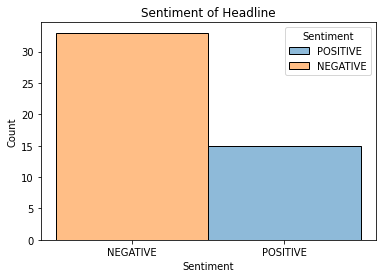

In [53]:
# sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Headline")

### Sentiment of Content

Text(0.5, 1.0, 'Sentiment of Content')

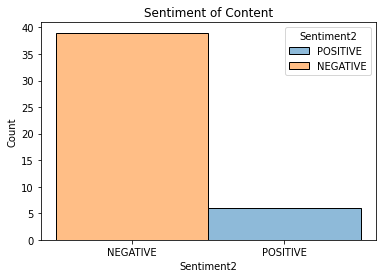

In [54]:
# sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE']).set_title("Sentiment of Content")

In [55]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [56]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)


## Each Articles - From Finviz

In [57]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [ ]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)

In [58]:
url = "https://finviz.com/news.ashx"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    link2 = []
    headline2 = []
    date2 = []


    #project_href = [i['href'] for i in soup.find_all('a', href=True)]


    for row in soup.find_all('tr', class_ = 'nn'):
        headline = row.find('a', class_ = 'nn-tab-link')
       
        if headline == None:
            continue

        headline2.append(headline.text)
        link = row.find('a', class_ = 'nn-tab-link')
        link2.append(link['href'])
        #print('1')
        #link2.append(link['href'])
        date = row.find('td', class_ = 'nn-date')
        date2.append(date)

        #sentence = tag.text.split(".")
        #sentence2.append(tag)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [59]:
df = pd.DataFrame(date2)

In [60]:
df['Date'] = df[0]
df['Headline'] = headline2
df = pd.DataFrame(list(zip(df['Date'], df['Headline'])), columns=['Date', 'Headline'])
df['Links'] = link2

In [61]:
# # Filtering only links starting with https
# df['Links_True'] = list(
#     map(lambda x: x.startswith('http'), df['Links']))

# df = df[df['Links_True'] == True].reset_index(drop=True)

In [62]:
# Creating word count of headline (no longer needed after filtering https)
i = []
for string in df['Headline']:
    i.append(count_words(string))
df['word_count'] = i

In [65]:
# Collect entire articles

headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

article = []

for url in df['Links']:
    req = Request(url, headers=headers)

    try:
        contents = urlopen(req).read() 
        soup = BeautifulSoup(contents, features="html.parser")

        p = soup.find_all('p')
        paragraphs = []
        for x in p:
            paragraphs.append(str(x))

        paragraphs = ''.join(paragraphs)

        article.append(paragraphs) 

    except urllib.error.HTTPError as err:
        print(err.code)

    except socket.timeout as se:
        print("socket timeout")

df['article'] = article


In [63]:
# Sentiment analysis of headline
df['Sentiment_Head'] = -2

sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment_Head'] = sentiment
df['Score_Head'] = sentiment_score

In [ ]:
# Sentiment analysis of Article Summary
df['Sentiment_Article'] = -2

sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment_Article'] = sentiment
df['Score_Article'] = sentiment_score

In [ ]:
# Summary of Articles
summary_pipeline = pipeline("summarization", model="pszemraj/long-t5-tglobal-base-16384-book-summary")

summary = [None] * len(df)
index = -1
for articles in df['article']:
    index+=1
    result = summary_pipeline(articles[:512])[0]
    summary[index] = result
df['summary'] = summary